# DistilBERT and ktrain

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import transformers
import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Import the data
jobs=pd.read_csv("fake_job_postings.csv")

In [3]:
# Combine some textual categories into one while ignoring NaN values
jobs['description']=jobs[['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']].fillna('').astype(str).apply(' '.join, axis=1)
jobs=jobs[['description', 'fraudulent']]

In [4]:
# Since there are significantly more real postings than fake, we will have to perform downsampling
# Downsampling reduces the number of samples in the majority class to match the number of samples in the minority class
# Make the ratio of real:fake jobs = 1:1
real=jobs[jobs['fraudulent']==0]
fake=jobs[jobs['fraudulent']==1]

from sklearn.utils import resample
real_resample=resample(real, replace=False, n_samples=len(fake), random_state=42)
jobs=pd.concat([real_resample, fake])

# Shuffle the dataset
jobs=jobs.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
# Split into train and test dataset
x_train, x_test, y_train, y_test=train_test_split(jobs['description'], jobs['fraudulent'], test_size=0.20,  random_state = 434)

In [16]:
# Define our model
# base: smaller version of distilbert
# uncased: casing does not matter, all will be converted to lower case
model_name = 'distilbert-base-uncased'
categories=['real', 'fake']

transformer=text.Transformer(model_name, maxlen=512, class_names=categories)


In [17]:
# Data preprocessing
train_dataset=transformer.preprocess_train(x_train.values, y_train.values)
test_dataset=transformer.preprocess_test(x_test.values, y_test.values)

preprocessing train...
language: en
train sequence lengths:
	mean : 339
	95percentile : 743
	99percentile : 980


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 321
	95percentile : 729
	99percentile : 903


In [18]:
# Get our model
model_DistilBert=transformer.get_classifier()

In [19]:
learner=ktrain.get_learner(model_DistilBert, train_data=train_dataset,val_data=test_dataset, batch_size=16)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
86/86 [==============================] - 1189s 14s/step - loss: 0.6952 - accuracy: 0.4927
Epoch 2/10
86/86 [==============================] - 1188s 14s/step - loss: 0.6801 - accuracy: 0.6136
Epoch 3/10
86/86 [==============================] - 1242s 14s/step - loss: 0.4694 - accuracy: 0.8006
Epoch 4/10
86/86 [==============================] - 1269s 15s/step - loss: 0.2830 - accuracy: 0.8941
Epoch 5/10
86/86 [==============================] - 1668s 19s/step - loss: 0.4793 - accuracy: 0.7750
Epoch 6/10
86/86 [==============================] - 1484s 17s/step - loss: 0.6989 - accuracy: 0.5237
Epoch 7/10
86/86 [==============================] - 4446s 52s/step - loss: 0.7184 - accuracy: 0.4865
Epoch 8/10
86/86 [==============================] - 71s 637ms/step - loss: 19.6470 - accuracy: 0.4688


done.
Visually inspect loss plot and select learning rate associated with falling loss


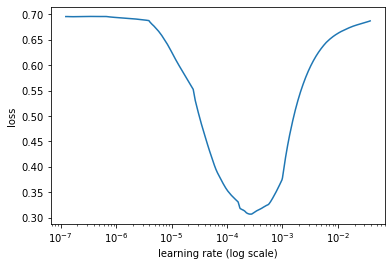

In [20]:
# Find an appropriate learning rate for training 
learner.lr_find(show_plot=True, max_epochs=10)

In [20]:
# The steepest slope happened at around 10^-4, where the loss decreased most rapidly
learner.fit_onecycle(1e-4,1)



begin training using onecycle policy with max lr of 0.0001...
87/87 [==============================] - 2059s 24s/step - loss: 0.4534 - accuracy: 0.7762 - val_loss: 0.2843 - val_accuracy: 0.9078


In [21]:
# Evaluate the results
learner.validate(class_names=categories)

11/11 [==============================] - 114s 10s/step
              precision    recall  f1-score   support

        real       0.97      0.84      0.90       176
        fake       0.86      0.98      0.91       171

    accuracy                           0.91       347
   macro avg       0.92      0.91      0.91       347
weighted avg       0.92      0.91      0.91       347



array([[148,  28],
       [  4, 167]], dtype=int64)

Accuracy of DistilBert Model:  0.9077809798270894


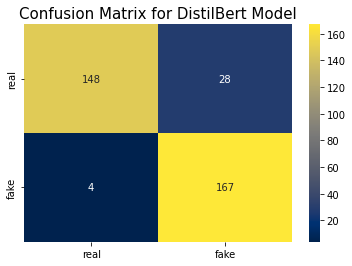

In [43]:
# Plot a confusion matrix to illustrate the prediction and result
confusion_matrix=np.array([[148,  28],[  4, 167]])
categories=['real', 'fake']
plt.title('Confusion Matrix for DistilBert Model', fontsize=15)
sb.heatmap(confusion_matrix, annot=True, fmt="d", cmap='cividis', xticklabels=categories, yticklabels=categories)  

total=len(x_test)
correct_pred=148+167
print("Accuracy of DistilBert Model: ", correct_pred/total)

In [29]:
# Analyse the top 5 wrong predictions with the most losses
learner.view_top_losses(n=5, preproc=transformer)

11/11 [==============================] - 91s 8s/step
----------
id:92 | loss:3.2 | true:fake | pred:real)

----------
id:67 | loss:1.92 | true:real | pred:fake)

----------
id:189 | loss:1.9 | true:real | pred:fake)

----------
id:271 | loss:1.87 | true:fake | pred:real)

----------
id:240 | loss:1.84 | true:real | pred:fake)



In [39]:
# Display summary of learner model
model_DB=learner.model
model_DB.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Save model
model_DB.save_weights('distilbert_model.h5')

**Accuracy of DistilBert: 0.908**

Despite being smaller and having fewer parameters than the full-scale BERT models, DistilBert still performed rather well on a wide range of natural language processing tasks like text classification in this case. This is because DistilBert is trained to learn general language representations and can thus be fine-tuned for various downstream tasks like text classification etc. 

In the future, we can play around with the other pre-trained models, especially the bigger and more complex ones that have larger number of parameters, enabling them to learn more intricate patterns and capture finer details in texts. These bigger models can be beneficial for complex NLP tasks where subtle nuances and context play a crucial role, such as language translation etc. 

# Gradient Boosting

Gradient boosting is one of the most popular machine learning techniques in recent years which works by ensembling many decision trees in order to perform regression or classification. We are going to be comparing the accuracy of 3 gradient boosting algorithm, XGBoost, LightGBM and CatBoost, which are the most common algorithms.

# XGBoost

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# For cross-validation
from sklearn.model_selection import cross_val_score

# For saving models
import pickle

In [6]:
# Split into train and test dataset
x_train, x_test, y_train, y_test=train_test_split(jobs['description'], jobs['fraudulent'], test_size=0.20,  random_state = 44)

# Preprocessing the data
vectorizer=TfidfVectorizer(max_features=50)
x_train_vec=vectorizer.fit_transform(x_train)
x_test_vec=vectorizer.fit_transform(x_test)

In [13]:
# Define our model
model_xgb=XGBClassifier(n_estimators=100, tree_method='hist', subsample=0.67, n_jobs=6, random_state=42)

# Define the datasets to evaluate each iteration
evalset=[(x_train_vec, y_train), (x_test_vec, y_test)]

# Fit our model
model_xgb.fit(x_train_vec, y_train, eval_metric='logloss', eval_set=evalset)

[0]	validation_0-logloss:0.55160	validation_1-logloss:0.71997
[1]	validation_0-logloss:0.46485	validation_1-logloss:0.73158
[2]	validation_0-logloss:0.40057	validation_1-logloss:0.70719
[3]	validation_0-logloss:0.34357	validation_1-logloss:0.66148
[4]	validation_0-logloss:0.30007	validation_1-logloss:0.64015


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.26970	validation_1-logloss:0.64652
[6]	validation_0-logloss:0.24374	validation_1-logloss:0.62797
[7]	validation_0-logloss:0.21852	validation_1-logloss:0.60042
[8]	validation_0-logloss:0.20037	validation_1-logloss:0.58449
[9]	validation_0-logloss:0.18317	validation_1-logloss:0.57915
[10]	validation_0-logloss:0.16761	validation_1-logloss:0.55688
[11]	validation_0-logloss:0.15358	validation_1-logloss:0.55710
[12]	validation_0-logloss:0.14149	validation_1-logloss:0.55531
[13]	validation_0-logloss:0.13506	validation_1-logloss:0.54289
[14]	validation_0-logloss:0.12714	validation_1-logloss:0.54275
[15]	validation_0-logloss:0.11667	validation_1-logloss:0.53163
[16]	validation_0-logloss:0.11236	validation_1-logloss:0.52820
[17]	validation_0-logloss:0.10582	validation_1-logloss:0.51628
[18]	validation_0-logloss:0.09760	validation_1-logloss:0.51880
[19]	validation_0-logloss:0.09158	validation_1-logloss:0.51815
[20]	validation_0-logloss:0.08636	validation_1-logloss:0.524

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=6, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [14]:
# Save the model
pickle.dump(model_xgb, open('xgb_model', "wb"))

In [54]:
model_xgb=pickle.load(open('xgb_model', "rb"))

Accuracy of XGBoost Model:  0.7867435158501441


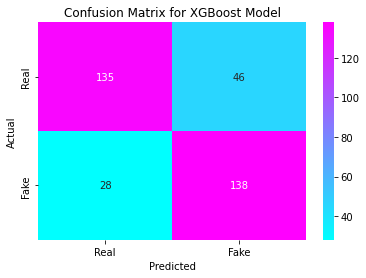

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Test on our test dataset
y_pred=model_xgb.predict(x_test_vec)

# Display accuracy and confusion matrix
print("Accuracy of XGBoost Model: ", accuracy_score(y_test, y_pred))
cm2=confusion_matrix(y_test, y_pred)
labels=['Real', 'Fake']
sb.heatmap(cm2, annot=True, cmap='cool', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

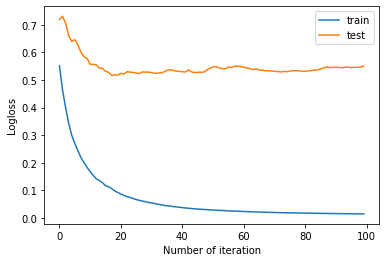

In [19]:
# Retrive performance metrics and plot them

results=model_xgb.evals_result()
plt.plot(results['validation_0']['logloss'], label="train")
plt.plot(results['validation_1']['logloss'], label="test")
plt.legend()
plt.xlabel('Number of iteration')
plt.ylabel('Logloss')
plt.show()

Test Dataset has a higher loss than training dataset. This is often an indication of overfitting. Our model learns the training data too well and fails to generalize to new, unseen data. A way to address the issue is through cross-validation.

In [ ]:
# Find mean accuracy with cross-validation
x=jobs['description']
y=jobs['fraudulent']

x=vectorizer.fit_transform(x)
cross_xgb=cross_val_score(model_xgb, x, y, cv = 5)
print("Mean Accuracy for XGBoost Model: ", np.average(cross_xgb))
plt.figure(figsize=(4,6))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Results for XGBoost Model", fontsize=15)
sb.boxplot(data=cross_xgb, palette='cool')

**Without cross-validation: 0.787\
With cross-validation: 0.851**

Cross-validation results show higher accuracy. It could be due to the following:

- Dataset Split: Cross-validation splits the dataset into multiple subsets and trains the model on different combinations of these subsets, providing a more comprehensive evaluation of the model's performance by taking the average accuracy across different splits. On the other hand, the test set represents a single evaluation on a specific portion of the data, which may have different characteristics compared to the training data used for cross-validation

- Data Variability: The test set may contain samples that are more challenging as they may contain different patterns from the rest compared to the training data used in cross-validation, leading to variations in performance

# LightGBM

In [24]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [22]:
# Define the LightGBM model
model_lgbm=LGBMClassifier(n_estimators=100, subsample=0.67, n_jobs=6, random_state=42, force_col_wise=True)

In [28]:
# Fit the model
model_lgbm.fit(x_train_vec, y_train, eval_metric='logloss', eval_set=evalset)

[1]	training's binary_logloss: 0.641173	valid_1's binary_logloss: 0.694625
[2]	training's binary_logloss: 0.597282	valid_1's binary_logloss: 0.692708
[3]	training's binary_logloss: 0.558835	valid_1's binary_logloss: 0.696831
[4]	training's binary_logloss: 0.52425	valid_1's binary_logloss: 0.69797
[5]	training's binary_logloss: 0.494236	valid_1's binary_logloss: 0.695007
[6]	training's binary_logloss: 0.468529	valid_1's binary_logloss: 0.702315
[7]	training's binary_logloss: 0.440362	valid_1's binary_logloss: 0.684221
[8]	training's binary_logloss: 0.417905	valid_1's binary_logloss: 0.674304
[9]	training's binary_logloss: 0.397519	valid_1's binary_logloss: 0.662839
[10]	training's binary_logloss: 0.376716	valid_1's binary_logloss: 0.64553
[11]	training's binary_logloss: 0.359587	valid_1's binary_logloss: 0.640685
[12]	training's binary_logloss: 0.342405	valid_1's binary_logloss: 0.63144
[13]	training's binary_logloss: 0.32602	valid_1's binary_logloss: 0.621868
[14]	training's binary_log

LGBMClassifier(force_col_wise=True, n_jobs=6, random_state=42, subsample=0.67)

In [47]:
# Save the model
pickle.dump(model_lgbm, open('lgbm_model', "wb"))

Accuracy of LightGBM Model:  0.7809798270893372


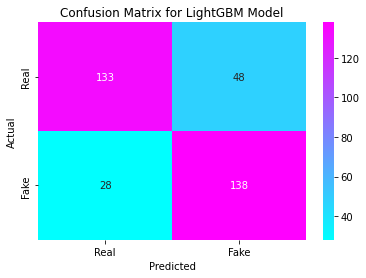

In [48]:
# Test on our test dataset
y_pred=model_lgbm.predict(x_test_vec)

# Display accuracy and confusion matrix
print("Accuracy of LightGBM Model: ", accuracy_score(y_test, y_pred))
cm1=confusion_matrix(y_test, y_pred)
labels=['Real', 'Fake']
sb.heatmap(cm1, annot=True, cmap='cool', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for LightGBM Model')
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

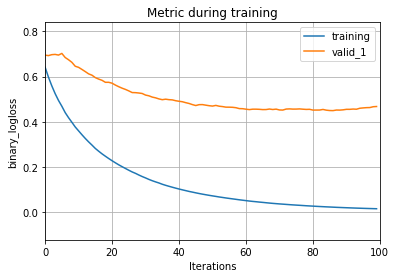

In [31]:
# Retrive performance metrics and plot them

lgb.plot_metric(model_lgbm)

Mean Accuracy for LightGBM Model:  0.8579467275241125


<AxesSubplot:title={'center':'Cross-Validation Results for LightGBM Model'}, ylabel='Accuracy'>

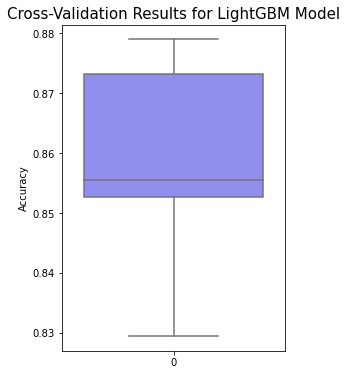

In [50]:
# Find mean accuracy with cross-validation
x=jobs['description']
y=jobs['fraudulent']

x=vectorizer.fit_transform(x)
cross_lgbm=cross_val_score(model_lgbm, x, y, cv = 5)
print("Mean Accuracy for LightGBM Model: ", np.average(cross_lgbm))
plt.figure(figsize=(4,6))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Results for LightGBM Model", fontsize=15)
sb.boxplot(data=cross_lgbm, palette='cool')

LightGBM

**Without Cross-vaidation: 0.781\
With Cross-validation: 0.858**

# CatBoost

In [5]:
from catboost import CatBoostClassifier, Pool

In [8]:
# Define the CatBoost model
model_cat=CatBoostClassifier(n_estimators=100, max_leaves=31, subsample=0.67, thread_count=6, random_state=42)

In [9]:
# Fit the model
model_cat.fit(x_train_vec, y_train)

Learning rate set to 0.097799
0:	learn: 0.6614803	total: 162ms	remaining: 16s
1:	learn: 0.6292012	total: 172ms	remaining: 8.45s
2:	learn: 0.5979800	total: 183ms	remaining: 5.9s
3:	learn: 0.5759304	total: 200ms	remaining: 4.79s
4:	learn: 0.5577612	total: 213ms	remaining: 4.05s
5:	learn: 0.5315567	total: 224ms	remaining: 3.51s
6:	learn: 0.5184917	total: 235ms	remaining: 3.12s
7:	learn: 0.5028046	total: 245ms	remaining: 2.82s
8:	learn: 0.4904764	total: 255ms	remaining: 2.58s
9:	learn: 0.4753439	total: 265ms	remaining: 2.39s
10:	learn: 0.4639442	total: 276ms	remaining: 2.23s
11:	learn: 0.4487138	total: 286ms	remaining: 2.1s
12:	learn: 0.4360921	total: 296ms	remaining: 1.98s
13:	learn: 0.4266706	total: 306ms	remaining: 1.88s
14:	learn: 0.4163832	total: 316ms	remaining: 1.79s
15:	learn: 0.4100081	total: 326ms	remaining: 1.71s
16:	learn: 0.4013398	total: 336ms	remaining: 1.64s
17:	learn: 0.3935745	total: 346ms	remaining: 1.58s
18:	learn: 0.3852692	total: 356ms	remaining: 1.52s
19:	learn: 0.37

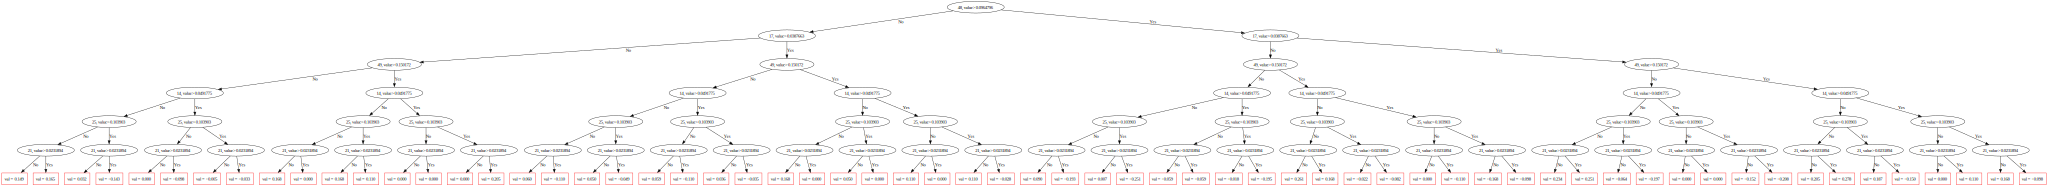

In [10]:
# Plot the first tree of the model
model_cat.plot_tree(tree_idx=0)

There are only 'FloatFeature' because our model doesn't have categorical features. 

Each node contains a feature index used for splitting the data at that particular node which corresponds to the column index of the input data. It also contains the threshold value for the splitting condition. Those with values less than or equal to threshold will proceed leftwards while those with values more than the threshold proceed rightwards. 


In [74]:
# Save the model
pickle.dump(model_lgbm, open('cat_model', "wb"))

Accuracy of CatBoost Model:  0.7492795389048992


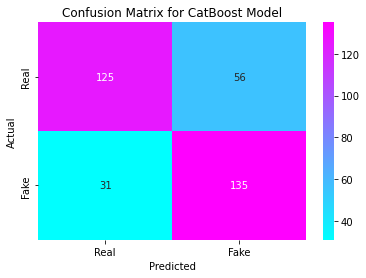

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Test on our test dataset
y_pred=model_cat.predict(x_test_vec)

# Display accuracy and confusion matrix
print("Accuracy of CatBoost Model: ", accuracy_score(y_test, y_pred))
cm3=confusion_matrix(y_test, y_pred)
labels=['Real', 'Fake']
sb.heatmap(cm3, annot=True, cmap='cool', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for CatBoost Model')
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

Unfortunately, CatBoost is memory-intensive, especially since we are working with a rather big dataset and thus we are unable to proceed with cross-validation.

**Accuracies of gradient boosting models**\

XGBoost: 0.787\
LightGBM: 0.781\
CatBoost: 0.749

Evidently CatBoost pales in comparison with XGBoost and LightGBM in terms of accuracy. However, it only means that CatBoost may not work best for this particular project. Every model has their own strengths and weaknesses and works differently on different data. Besides, there are also other factors to account for when deciding the most suitable algorithm such as speed and resource utilization. Furthermore, there are also other gradient boosting algorithms that we have not yet experimented. 

When time permits, we hope to explore other models available and do a thorough comparison among the models based on accuracy, time and space. 